In [24]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [25]:
PathWindows = r"D:\Учеба\Практика\Диплом\gamma"
LibraryPathWindows = r"D:\Учеба\Практика\Диплом\gamma\SpectrumsMeasurementsLibrary"
LibraryPathLinux = r"/home/danis/work/python_works/gamma"
sys.path.insert(0, LibraryPathWindows)
sys.path.insert(0, PathWindows)
sys.path.insert(0, LibraryPathLinux)

In [26]:
from GammaRayInteractions.Materials import Material, R
from CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices
from NumericalMethods.simpson_rule import simpson_rule

In [27]:
brem = R(50, 1e-2).emitted_bremsstrahlung(0.075)

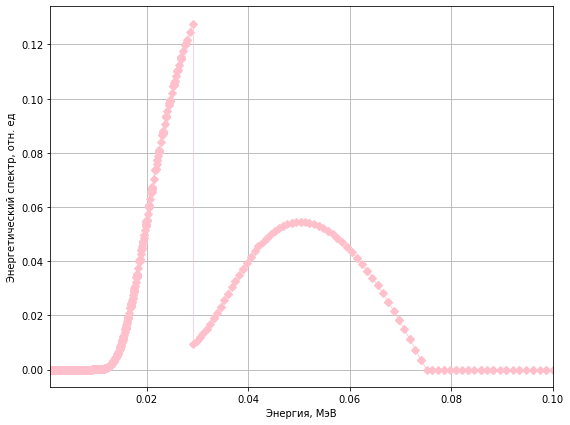

In [28]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(ENERGY_MESH, brem, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

In [29]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel
number_of_channels_with_open_detector = 1

In [30]:
level = 0.1

In [31]:
EDGE_METHOD_channels = [k_edge_method_transmission_function(num, level) for num in range(first_channel, last_channel+1)]
IDEAL_channels = [ideal_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]
ROSS_METHOD_channels = [ross_method_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]

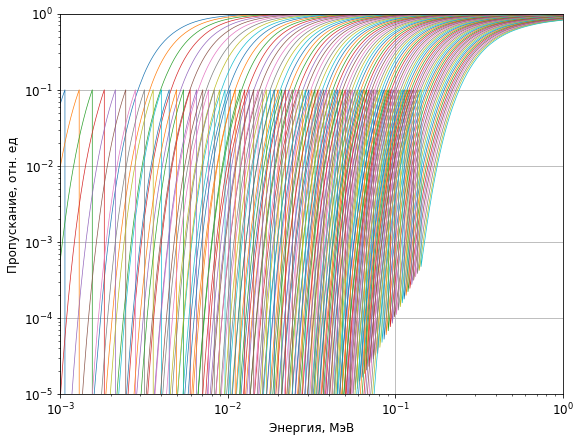

In [32]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in EDGE_METHOD_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in IDEAL_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 0.15e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in ROSS_METHOD_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlim(1e-3, 0.15e0)
# ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

In [ ]:
def split_into_areas(array):
    """
    Разделяет массив на части по три элемента
    (нужно переделать функцию)
    """
    triplets_num = len(array) / 3
    return np.array(np.split(array, triplets_num))

In [ ]:
def polinom_coeff(mesh_triplet):
    """
    Принимает массив со значениями узлов элементарного участка интегрирования
    по правилу Симпсона [x0, x1, x2]
    Возвращает коэффициенты интегрирования по правилу Симпсона [c0, c1, c2]
    Для произвольной сетки узлов
    """
    x = mesh_triplet
    x21 = x[2]-x[1]
    x20 = x[2]-x[0]
    x10 = x[1]-x[0]
    c0 = (6*x20*x10 + 2*x20**2 - 3*x20*(x10+x20)) / (6*x10)
    c1 = x20**3 / (6*x10*x21)
    c2 = (x20*(2*x20 - 3*x10)) / (6*x21)
    return np.array([c0, c1, c2])

In [ ]:
def polinom_coeff_h(mesh_triplet):
    """
    Принимает массив со значениями узлов элементарного участка интегрирования
    по правилу Симпсона [x0, x1, x2]
    Возвращает коэффициенты интерполяционного многочлена при 
    интегрировании по правилу Симпсона [c0, c1, c2]
    Для сетки узлов с равномерным шагом
    """
    x = mesh_triplet
    x21 = x[2]-x[1]
    x20 = x[2]-x[0]
    x10 = x[1]-x[0]
    c0 = (1/6)*x20
    c1 = (4/6)*x20
    c2 = (1/6)*x20
    return np.array([c0, c1, c2])

In [ ]:
def polinom_coefficients_vectorize(split_areas):
    """
    Принимает массив с тройками узлов [[x0, x1, x2], [x3, x4, x5],... [xn-2, xn-1, xn]]
    и возвращает подобный массив, но с коэффициентами интерполяционного многочлена при 
    интегрировании по правилу Симпсона
    [[с0, с1, с2], [с3, с4, с5],... [сn-2, сn-1, сn]]
    Является векторизированным вариантом фунции polinom_coeff
    """
    return np.array(list(map(polinom_coeff, split_areas)))

In [ ]:
def concatenate_function_list(a, b):
    return a[:len(a) -1] + [a[-1] + b[0]] + b[1:]


def concatenate_mesh_list(a, b):
    return a[:len(a) -1] + [b[0]] + b[1:]


def combine_areas(areas, jumps_list, mesh):
    
    if isinstance(areas, np.ndarray):
        areas = areas.tolist()
    
    mesh_areas = split_into_areas(mesh)
    mesh_areas = mesh_areas.tolist()
    
    result_f = areas[0]
    result_m = mesh_areas[0]
    
    for i, part in enumerate(areas):
        if i < len(areas) - 1:
            if mesh.tolist().index(mesh_areas[i][-1]) in jumps_list:
                result_f = concatenate_function_list(result_f, areas[i + 1])
                result_m = concatenate_mesh_list(result_m, mesh_areas[i + 1])
            else:
                result_f += areas[i + 1]
                result_m += mesh_areas[i + 1]
                
    return result_m, result_f

In [ ]:
def simpson_rule(function, mesh=ENERGY_MESH, function_jumps=[], regime='s'):
    """
    Возвращает коэффициенты интегрирования по правилу Симпсона
    Параметры:
        1) function подынтегральная функция
        2) mesh сетка узлов
    """
    function_values_areas = split_into_areas(function) # подынтегральная функция разбитая на тройки
    energy_mesh_areas = split_into_areas(mesh) # сетка интегрирования разбитая на тройки
    # коэффициенты интерполяционного многочлена при интегрировании по правилу Симпсона
    integration_coefficients = polinom_coefficients_vectorize(energy_mesh_areas)
    # коэффициенты аппроксимации при интегрировании по правилу Симпсона
    approximation_coefficients = integration_coefficients*function_values_areas
    
    edges = edges_indices() # все индексы скачков
    for ind in function_jumps:
        edges.remove(ind) # удаление из списка скачков, которые нужно добавить при востановлении
        
    if regime == 's':
        return approximation_coefficients.sum()
    if regime == 'c':
        approximation_coefficients = combine_areas(approximation_coefficients, edges, mesh)[1]
        return approximation_coefficients
    if regime == 'm':
        approximation_mesh = combine_areas(approximation_coefficients, edges, mesh)[0]
        return approximation_mesh

In [ ]:
signals_simpson = [simpson_rule(brem*r) for r in ROSS_METHOD_channels]

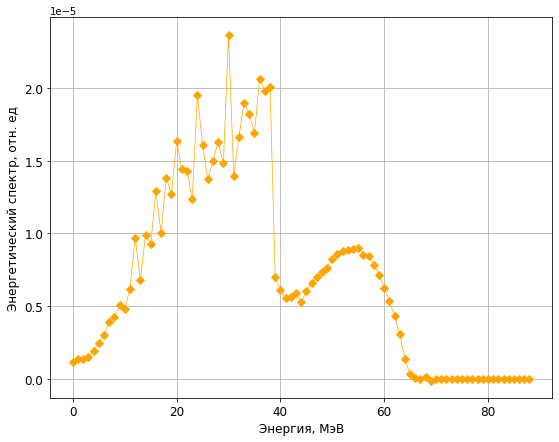

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(list(range(len(signals_simpson))), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')
# ax.plot(e3, mean_spectrum, ls='-', marker='D', lw='0.7', ms=5, color='orange')
# ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

In [808]:
Matrix = [simpson_rule(r, regime='c', function_jumps=[1541]) for r in ROSS_METHOD_channels]

In [809]:
new_en = simpson_rule(ROSS_METHOD_channels[0], regime='m', function_jumps=[1541])

In [810]:
sp = [0 for i in range(len(signals_simpson))]
norm = [0 for i in range(len(signals_simpson))]
decb = [0 for i in range(len(signals_simpson))]
dev = [0 for i in range(len(signals_simpson))]

In [811]:
import time
# восстановление спектра методом Голда на основании К-фильтров
start_time = time.time()
sp, norm, dev = Gold(Matrix, signals_simpson, ENERGY_MESH, brem, new_en, 1, 10000, w=True, d=False)[:3]
print(f'{round(time.time()-start_time, 6)} секунд')

4.342777 секунд


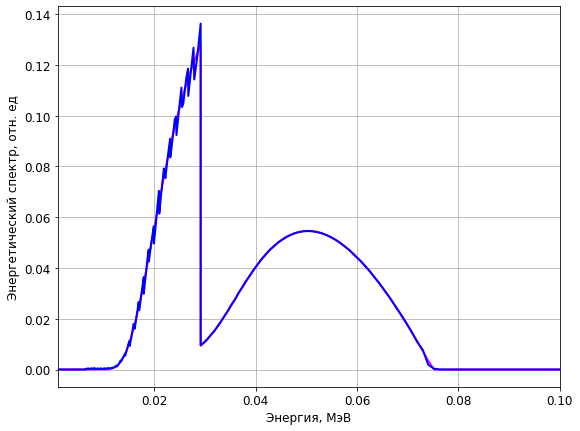

In [812]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(ENERGY_MESH, brem, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_en, sp, ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)